# Problem 3 - State Estimation

## Agenda
- Problem Description
- Problem Implementation
- Alternative Problems
- Wrap-Up

## Problem Description
- <b>Consider a grid for which we have sufficient metering data <i>z<sub>meter</sub></i> and discover the state vector <i>x</i> that fully characterizes the condition in which the grid is being operated, given the grid static information of its structure and corresponding component models.<b>

    _______________________________________________________________________________________________________________________

Considered "Kite" 5 Bus Network
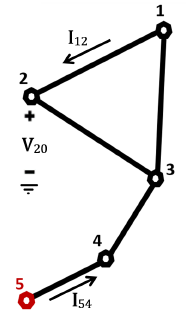

- <b>Implementation.<b>

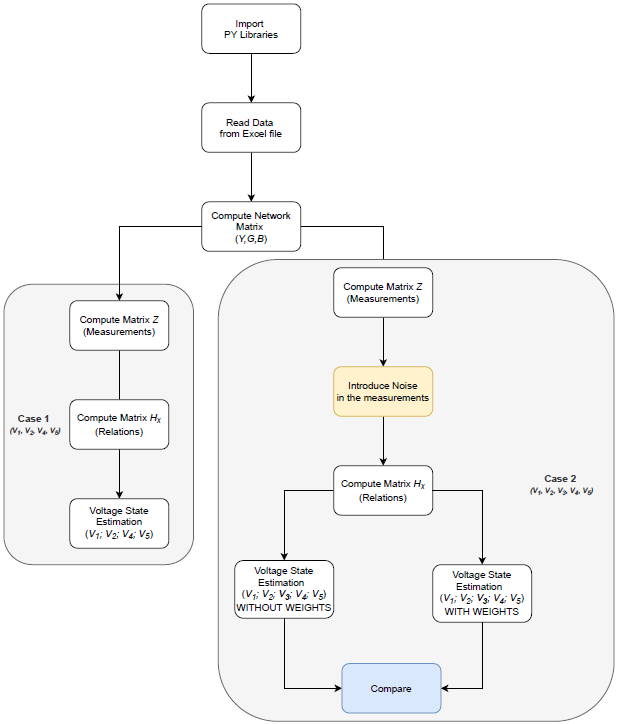

<b>Import Python Libraries

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

<b>Parameters

In [23]:
networkFactor = 100    # To change the characteristics of the network (Y)
cosPhi=0.95            # Value of teta
m=100                  # Number of Iterations   
sig=0.5                # Noise factor 

<b>Import data (From Excel file)

In [24]:
Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Info', header=None))
# Information about the slack bus
SlackBus=Info[0,1]
print ("Slack Bus: ", SlackBus,"\n")

# Network Information
Net_Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Y_Data'))
print ("Lines information (Admitances)\n", Net_Info, "\n")

#Power Information (train)
Power_Info = np.array(pd.read_excel (r'DASG_Prob2_new.xlsx', sheet_name='Load(t,Bus)'))
Power_Info = np.delete(Power_Info,[0],1)
print ("Power consumption information (time, Bus) - (Train)\n", Power_Info, "\n")

time=Power_Info.shape[0]
P=np.dot(-Power_Info,np.exp(complex(0,1)*np.arccos(cosPhi)))
I=np.conj(P[2,:])

Slack Bus:  5 

Lines information (Admitances)
 [[1 2 '0,01-0,1i']
 [1 3 '0,02-0,2i']
 [2 3 '0,03-0,2i']
 [3 4 '0,03-0,2i']
 [4 5 '0,02-0,2i']] 

Power consumption information (time, Bus) - (Train)
 [[0.332 0.064 0.084 0.12 ]
 [0.236 0.164 0.276 0.064]
 [0.224 0.708 1.572 0.072]
 [0.36  3.44  1.188 0.18 ]
 [1.332 2.176 0.484 1.464]
 [1.516 3.02  0.316 0.624]
 [0.92  0.916 0.404 2.772]
 [0.752 0.64  0.396 1.464]
 [1.828 0.684 0.576 0.576]
 [3.568 0.564 0.828 0.428]
 [0.78  0.356 0.728 0.348]
 [0.856 0.22  0.308 0.12 ]
 [0.684 0.528 0.256 0.44 ]] 



<b>Admittance Matrix(Y); Conductance Matrix(G); Susceptance Matrix(B)

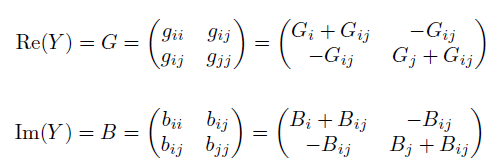

In [25]:
# Determine the number of Bus
nBus=max(np.max(Net_Info[:,0]),np.max(Net_Info[:,1]))

# Create the variable number of lines and the admitance matrix (Y)
nLines=Net_Info.shape[0]

Y=np.zeros((nBus,nBus), dtype=complex)

#Complete the Y matrix nad update the number of lines
for i in range (Net_Info.shape[0]):
    y_aux=Net_Info[i,2].replace(",",".")
    y_aux=y_aux.replace("i","j")
    Y[Net_Info[i,0]-1,Net_Info[i,0]-1]=Y[Net_Info[i,0]-1,Net_Info[i,0]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,1]-1]=Y[Net_Info[i,1]-1,Net_Info[i,1]-1]+complex(y_aux)*networkFactor
    Y[Net_Info[i,0]-1,Net_Info[i,1]-1]=Y[Net_Info[i,0]-1,Net_Info[i,1]-1]-complex(y_aux)*networkFactor
    Y[Net_Info[i,1]-1,Net_Info[i,0]-1]=Y[Net_Info[i,1]-1,Net_Info[i,0]-1]-complex(y_aux)*networkFactor

            
# Remove the slack bus from the admitance matrix            
Yl=np.delete(Y, np.s_[SlackBus-1], axis=0)
Yl=np.delete(Yl, np.s_[SlackBus-1], axis=1)

# Conductance Matrix
G=Yl.real

# Susceptance Matrix
B=Yl.imag 

print("The admitance matrix Y is:\n", Y, "\n")
print("The conductance matrix G is\n", G, "\n")
print("The susceptance matrix B is\n",B, "\n")

The admitance matrix Y is:
 [[ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]] 

The conductance matrix G is
 [[ 3. -1. -2.  0.]
 [-1.  4. -3.  0.]
 [-2. -3.  8. -3.]
 [ 0.  0. -3.  5.]] 

The susceptance matrix B is
 [[-30.  10.  20.   0.]
 [ 10. -30.  20.   0.]
 [ 20.  20. -60.  20.]
 [  0.   0.  20. -40.]] 



<b>1º State Estimation considering complete information about currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> (amplitude and angle) and not estimating <i>V<sub>3</sub></i>; Page 39

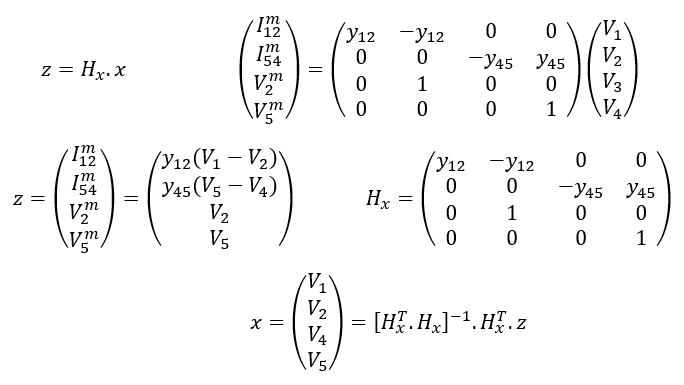

In [26]:
# Matrix Creation
b0s=np.zeros((4), dtype=complex)
A0s=np.zeros((4,4), dtype=complex)
v0s=np.zeros((5), dtype=complex)

# Voltage Computing (Reference)
v0s[0:4]=1+np.dot(np.linalg.inv(Yl),I)
v0s[4]=1

z=np.zeros((4), dtype=complex)

# Measurement values z 
z[0]=-Y[0][1]*v0s[0]+Y[0][1]*v0s[1]
z[1]=-Y[3][4]*v0s[4]+Y[3][4]*v0s[3]
z[2]=v0s[1]
z[3]=v0s[4]

print("The z vector is\n", z)

# Matrix Hx 
Hx=np.zeros((4,4), dtype=complex)
Hx[0][0]=-Y[0][1]
Hx[0][1]=Y[0][1]
Hx[1][2]=Y[3][4]
Hx[1][3]=-Y[3][4]
Hx[2][1]=1
Hx[3][3]=1

print("The Hx matrix is\n", Hx)

#State Variables (x) - These variables are the estimated voltages (V1; V2; V4; V5)
x = np.dot(Hx.T,Hx)
x = np.linalg.inv(x)        
x = np.dot(x,Hx.T)
x = np.dot(x, z)

print("The state variables x are\n", x)

The z vector is
 [0.1117607 -0.04431433j 2.4472    -0.80435574j 0.87962652-0.25388267j
 1.        +0.j        ]
The Hx matrix is
 [[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  1. +0.j]]
The state variables x are
 [0.88512062-2.43256005e-01j 0.87962652-2.53882666e-01j
 0.94806556-1.17166556e-01j 1.        -1.90596426e-14j]


<b>2º State Estimation considering RMS information of currents <i>I<sub>12</sub></i> and <i>I<sub>54</sub></i> and estimating <i>V<sub>3</sub></i>. Page 41
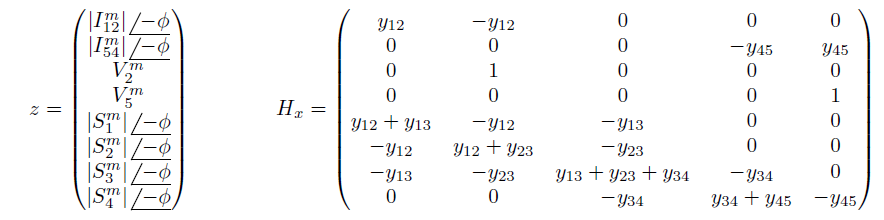

In [27]:
#Here we add some information the parameters (we add the I vector) to estimate the V3 so we need to change the Hx matrix too


# Matrix Creation
b0=np.zeros((8), dtype=complex)
b1=np.zeros((8), dtype=complex)
b2=np.zeros((8), dtype=complex)
A=np.zeros((8,5), dtype=complex)
v=np.zeros((5), dtype=complex)

# Voltage Computing (Reference)
v[0:4]=1+np.dot(np.linalg.inv(Yl),I)
v[4]=1

# Measurement values z (In that case, we are computing the currents and voltages but we can also measure them).
b0[0]=np.dot(np.absolute(np.dot(-Y[0,1],(v[0]-v[1]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
b0[1]=np.dot(np.absolute(np.dot(-Y[3,4],(1-v[3]))),np.exp(complex(0,-1)*np.arccos(cosPhi)))
b0[2]=v[1]
b0[3]=1
b0[4:8]=I #In that case, we are also including the vectors of aparente power

# New Matrix Hx (Page 42)
Hx1=np.zeros((8,5), dtype=complex)
Hx1[0][0]=-Y[0][1]
Hx1[0][1]=+Y[0][1]
Hx1[1][3]=+Y[3][4]
Hx1[1][4]=-Y[3][4]
Hx1[2][1]=1
Hx1[3][4]=1
Hx1[4][0]=-Y[0][1]-Y[0][2]
Hx1[4][1]=Y[0][1]
Hx1[4][2]=Y[0][2]
Hx1[5][0]=Y[0][1]
Hx1[5][1]=-Y[0][1]-Y[1][2]
Hx1[5][2]=Y[1][2]
Hx1[6][0]=Y[0][2]
Hx1[6][1]=Y[1][2]
Hx1[6][2]=-Y[0][2]-Y[1][2]-Y[2][3]
Hx1[6][3]=Y[2][3]
Hx1[7][2]=Y[2][3]
Hx1[7][3]=-Y[2][3]-Y[3][4]
Hx1[7][4]=Y[3][4]

print("The Hx matrix is\n", Hx1)




The Hx matrix is
 [[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]]


<b>2º a) - First, the weight of pseudo-measurements (Matrix W) <u>are not considered</u>;

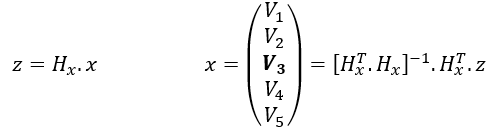

In [28]:
print("the hx matrix is\n", Hx1)


#Noise to be added to peseudo-measurements
e= np.random.normal(0.0, 1.0, size=(4,m))*sig

print(b0)
#Estimation not considering the noise 
#we new the transpose and the conjugate of the matrix Hx1
Hx1=np.matrix(Hx1)

print(Hx1)
x_new=np.dot(np.conj(Hx1).T,Hx1)


x_new=np.linalg.inv(x_new)
x_new=np.dot(x_new,np.conj(Hx1).T)
x_new=np.dot(x_new,b0)

#Matrix creation 
sx=np.zeros(5)
rms=np.zeros((5,m))
ei12a=np.zeros(m)
ei54a=np.zeros(m)

print("The I´s are\n", I)
#
b1=b0

for i in range(m):

    #Introduce error in the measurements (Matrix z) 
    b1[4:8]=I+e[:,i]
    print("The b1 matrix is\n", b1) 
    #Estimate the voltages based on measurements with the errors

    x_new_withnoise=np.dot(np.conj(Hx1).T,Hx1)
    x_new_withnoise=np.linalg.inv(x_new_withnoise)
    x_new_withnoise=np.dot(x_new_withnoise,np.conj(Hx1).T)
    x_new_withnoise=np.dot(x_new_withnoise,b1)

    x_new_withnoise=np.array(x_new_withnoise)
    x_new_withnoise=x_new_withnoise.reshape(5)
    
    #Accumulated value of estimations
    sx=sx+x_new_withnoise
    
    #Errors in the voltages
    rms[:,i]=np.sqrt(np.dot((x_new_withnoise-x_new),np.transpose(np.conjugate(x_new_withnoise-x_new)))) 
    # x0 is the initial estimation not considering the noise 
    # x is the estimation considering the noise 

    #Relative current errors (To be used in the graphics)
    ei12a[i]=np.divide(np.absolute(np.dot(Y[0,1],(x_new_withnoise[0]-x_new_withnoise[1])))-np.absolute(np.dot(Y[0,1],(v[0]-v[1]))),np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
    ei54a[i]=np.divide(np.absolute(np.dot(Y[3,4],(1-x_new_withnoise[3])))-np.absolute(np.dot(Y[3,4],(1-v[3]))),np.absolute(np.dot(Y[3,4],(1-v[3]))))

#Average Voltage Estimation
x_avg=sx/m
print("The average voltage estimation is\n", x_avg)

#Average Voltage RMS Error
ee=np.transpose(np.matrix,sum(np.transpose(rms)))/m
print("The average voltage RMS error is\n", ee)



the hx matrix is
 [[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]]
[ 0.1142144 -0.03754046j  2.4472    -0.80435574j  0.87962652-0.25388267j
  1.        +0.j         -0.2128    +0.06994398j -0.6726    +0.22107293j
 -1.4934    +0.49085684j -0.0684    +0.02248199j]
[[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]]
The I´s are
 [-0

C:\Users\berna\AppData\Local\Temp\ipykernel_7016\936764102.py:49: ComplexWarning: Casting complex values to real discards the imaginary part
  rms[:,i]=np.sqrt(np.dot((x_new_withnoise-x_new),np.transpose(np.conjugate(x_new_withnoise-x_new))))


<b>2º b) - Second, the weight of pseudo-measurements (Matrix W) <u>are considered</u>;
    
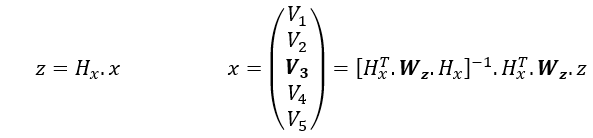

In [29]:
# The vector of errors is the same used in the first scenario 

#Matriz of the Weights (W)
W=np.zeros((8,8))
#Matriz of the Weights (W)
np.fill_diagonal(W[0:4], 0.001**-2)
np.fill_diagonal(W[4:8,4:8], sig**-2)

print(W)
#Estimation not considering the noise, but considering the weight 
Hx2=np.matrix(Hx1)
print(Hx2)
x_new_weight=np.dot(np.dot(np.conj(Hx2).T,W),Hx2)
x_new_weight=np.linalg.inv(x_new_weight)
x_new_weight=np.dot(np.dot(x_new_weight,np.conj(Hx2).T), W)
x_new_weight=np.dot(x_new_weight,b0)

#Matrix creation 
sx1=np.zeros(5)
rms1=np.zeros((5,m))
ei12a_weight=np.zeros(m)
ei54a_weight=np.zeros(m)

b2=b0

for i in range(m):
    
    #Introduce error in the measurements (Matrix z) 
    b2[4:8]=I+e[:,i]
    #Estimate the voltages based on measurements with the errors

    x_new_weight_withnoise=np.dot(np.dot(np.conj(Hx2).T,W),Hx2)
    x_new_weight_withnoise=np.linalg.inv(x_new_weight_withnoise)
    x_new_weight_withnoise=np.dot(np.dot(x_new_weight_withnoise,np.conj(Hx2).T), W)
    x_new_weight_withnoise=np.dot(x_new_weight_withnoise,b2)

    x_new_weight_withnoise=np.array(x_new_weight_withnoise)
    x_new_weight_withnoise=x_new_weight_withnoise.reshape(5)

    #Accumulated value of estimations
    sx1=sx1+x_new_weight_withnoise
    #Errors in the voltages
    rms1[:,i]=np.sqrt(np.dot((x_new_weight_withnoise-x_new_weight),np.transpose(np.conjugate(x_new_weight_withnoise-x_new_weight))))
    
    # x0 is the initial estimation not considering the noise
    # x is the estimation considering the noise

    #Relative current errors (To be used in the graphics)
    ei12a_weight[i]=np.divide(np.absolute(np.dot(Y[0,1],(x_new_weight_withnoise[0]-x_new_weight_withnoise[1])))-np.absolute(np.dot(Y[0,1],(v[0]-v[1]))),np.absolute(np.dot(Y[0,1],(v[0]-v[1]))))
    ei54a_weight[i]=np.divide(np.absolute(np.dot(Y[3,4],(1-x_new_weight_withnoise[3])))-np.absolute(np.dot(Y[3,4],(1-v[3]))),np.absolute(np.dot(Y[3,4],(1-v[3]))))    

ei12a=abs(ei12a)
ei12a_weight=abs(ei12a_weight)
ei54a=abs(ei54a)
ei54a_weight=abs(ei54a_weight)

print("The relative current errors are\n", ei12a)
print("The relative current errors considering the weight are\n", ei12a_weight)
print("The relative current errors are\n", ei54a)
print("The relative current errors considering the weight are\n", ei54a_weight)
   
#Average Voltage Estimation
x_avg_weight=sx1/m

print("The average voltage estimation considering the weight is\n", x_avg_weight)

#Average Voltage RMS Error
ee1=np.transpose(np.matrix,sum(np.transpose(rms1)))/m

print("The average voltage RMS error considering the weight is\n", ee1)




[[1.e+06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 1.e+06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 1.e+06 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 1.e+06 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 4.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 4.e+00 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 4.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 0.e+00 4.e+00]]
[[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]]
The relative current errors are
 [0.66778646 0.4200445  0.61069195 0.20595211 1.76267016 0.03637919
 0.97404081 1.24476292 0.56800458 0.299745

C:\Users\berna\AppData\Local\Temp\ipykernel_7016\3453985572.py:43: ComplexWarning: Casting complex values to real discards the imaginary part
  rms1[:,i]=np.sqrt(np.dot((x_new_weight_withnoise-x_new_weight),np.transpose(np.conjugate(x_new_weight_withnoise-x_new_weight))))


<b>Plot Results

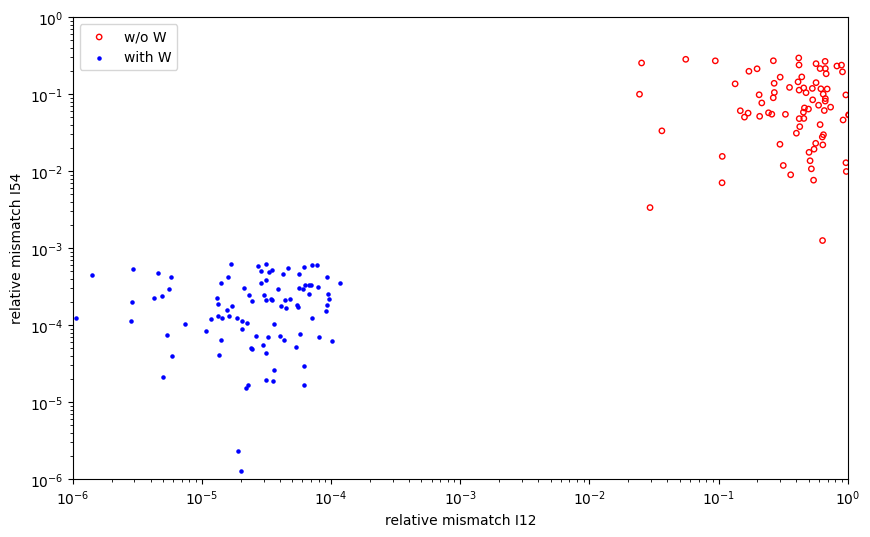

[[ 1.-10.j -1.+10.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j -2.+20.j  2.-20.j]
 [ 0. +0.j  1. +0.j  0. +0.j  0. +0.j  0. +0.j]
 [ 0. +0.j  0. +0.j  0. +0.j  0. +0.j  1. +0.j]
 [ 3.-30.j -1.+10.j -2.+20.j  0. +0.j  0. +0.j]
 [-1.+10.j  4.-30.j -3.+20.j  0. +0.j  0. +0.j]
 [-2.+20.j -3.+20.j  8.-60.j -3.+20.j  0. +0.j]
 [ 0. +0.j  0. +0.j -3.+20.j  5.-40.j -2.+20.j]]


In [30]:
plt.figure(figsize=(10, 6))

# Without W
plt.scatter(ei12a, ei54a, facecolors='none', edgecolors='r', label='w/o W', s=15)

# With W
plt.scatter(ei12a_weight, ei54a_weight, color='b', label='with W', s=5)

# Log scale
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e-6, 1)
plt.ylim(1e-6, 1)
# legend
plt.xlabel('relative mismatch I12')
plt.ylabel('relative mismatch I54')
plt.legend()
plt.show()

print(Hx1)

# Extra Project Goals
Think about an interesting variation to this problem or a different way to solve and implement it !!!

Some ideas:
- Assume you have to chose just two out of four possible pseudo-measurements, S<sup>m</sup><sub>1</sub> , S<sup>m</sup><sub>2</sub> , S<sup>m</sup><sub>3</sub> , S<sup>m</sup><sub>4</sub> . What would be your choices and why? Chose based on probable accuracy of the resulting estimation.
- Assume that <i>I<sub>12</sub>=0</i>. Under this assumption, one of two possible situations may be occuring: either branch 1-2 is out of service (<i>y<sub>12</sub>=0</i>) or the corresponding current meter is malfunctioning. Decide about the most probable situation based on the accuracy of the corresponding estimation. as in the previous exercice, use the matrix <i>R<sub>x</sub></i> andd consider different matrices <i>W<sub>z</sub></i> including the identity matrix. Elaborate on the effects of <i>W<sub>z</sub></i>.  


In [31]:


list_tuples = []
for i in range(len(I)):
    for j in range(len(I)):
        if i<j:
            list_tuples.append((I[i],I[j]))

b3 = b0[:6]

lists_betas = []

for i in range(len(list_tuples)):
    
    b3_copy = np.copy(b3)  # Create a copy of b3
    b3_copy[4] = list_tuples[i][0]
    b3_copy[5] = list_tuples[i][1]
    lists_betas.append(b3_copy)  # Append the copy to lists_betas

print(list_tuples)

 
#Compute the new H12 matrix by eliminating the 5 and the 6 element
    
H34 = np.delete(Hx1, [4,5], axis=0)
    
#Compute the new H13 matrix by eliminating the 5 and the 8 element

H24 = np.delete(Hx1, [4,6], axis=0)

#Compute the new H14 matrix by eliminating the 5 and the 8 element

H23 = np.delete(Hx1, [4,7], axis=0)

#Compute the new H23 matrix by eliminating the 6 and the 7 element

H14 = np.delete(Hx1, [5,6], axis=0)

#Compute the new H24 matrix by eliminating the 6 and the 8 element

H13 = np.delete(Hx1, [5,7], axis=0)

#Compute the new H34 matrix by eliminating the 7 and the 8 element

H12 = np.delete(Hx1, [6,7], axis=0)

#COmpute the gains HtWH
#
newW=np.delete(W, [6,7], axis=0)
newW=np.delete(newW, [6,7], axis=1)

print(np.shape(newW))
HtWH12 = np.dot(np.dot(np.conj(H12.T),newW),H12)
HtWH13 = np.dot(np.dot(np.conj(H13.T),newW),H13)
HtWH14 = np.dot(np.dot(np.conj(H14.T),newW),H14)
HtWH23 = np.dot(np.dot(np.conj(H23.T),newW),H23)
HtWH24 = np.dot(np.dot(np.conj(H24.T),newW),H24)
HtWH34 = np.dot(np.dot(np.conj(H34.T),newW),H34)

#Invert 
HtWH12 = np.linalg.inv(HtWH12)
HtWH13 = np.linalg.inv(HtWH13)
HtWH14 = np.linalg.inv(HtWH14)
HtWH23 = np.linalg.inv(HtWH23)
HtWH24 = np.linalg.inv(HtWH24)
HtWH34 = np.linalg.inv(HtWH34)
    
#Calculate the sum of the diagonals and verify what gives the least one
sum12 = np.trace(HtWH12)
sum13 = np.trace(HtWH13)
sum14 = np.trace(HtWH14)
sum23 = np.trace(HtWH23)
sum24 = np.trace(HtWH24)
sum34 = np.trace(HtWH34)

print("The sum of the diagonals of HtWH12 is: ", sum12.real)
print("The sum of the diagonals of HtWH13 is: ", sum13.real)
print("The sum of the diagonals of HtWH14 is: ", sum14.real)
print("The sum of the diagonals of HtWH23 is: ", sum23.real)
print("The sum of the diagonals of HtWH24 is: ", sum24.real)
print("The sum of the diagonals of HtWH34 is: ", sum34.real)

#Return the smallest one
min_sum = min(sum12.real, sum13.real, sum14.real, sum23.real, sum24.real, sum34.real)

print("The smallest sum is: ", min_sum)

#H34 is the best option

    
#############################    Second Part    ####################################
    
#Case 1
    
#Consider that the I12 = 0 and the y12 still exists
b3=b1
b3[0] = 0

print("The b1 matrix is\n", b1)
x_with_y=np.dot(np.dot(np.conj(Hx2).T,W),Hx2)
x_with_y=np.linalg.inv(x_with_y)
x_with_y=np.dot(np.dot(x_with_y,np.conj(Hx2).T), W)
x_with_y=np.dot(x_with_y,b3)

print("The x with y12 matrix is\n", x_with_y)

#Then compute the state of the problem that is the sum of the errors
#rms_y=np.sqrt(np.dot((x_with_y-x_new_weight_withnoise),np.transpose(np.conjugate(x_with_y-x_new_weight_withnoise))))

b3=b3.reshape(8,1)
error_withy=b3-np.dot(Hx2,x_with_y.T)  

#Case 2

#Consider that the I12 = 0 and the y12 is 0

#New Hx matrix with y12=0
Hx3=np.zeros((8,5), dtype=complex)

Hx3=Hx1


Hx3[0,0]=0
Hx3[0,1]=0
Hx3[1,3]=+Y[3][4]
Hx3[1,4]=-Y[3][4]
Hx3[2,1]=1
Hx3[3,4]=1
Hx3[4,0]=-Y[0][2]
Hx3[4,1]=0
Hx3[4,2]=Y[0][2]
Hx3[5,0]=0
Hx3[5,1]=-Y[1][2]
Hx3[5,2]=Y[1][2]
Hx3[6,0]=Y[0][2]
Hx3[6,1]=Y[1][2]
Hx3[6,2]=-Y[0][2]-Y[1][2]-Y[2][3]
Hx3[6,3]=Y[2][3]
Hx3[7,2]=Y[2][3]
Hx3[7,3]=-Y[2][3]-Y[3][4]
Hx3[7,4]=Y[3][4]

x_wo_y12=np.dot(np.dot(np.conj(Hx3).T,W),Hx3)
x_wo_y12=np.linalg.inv(x_wo_y12)
x_wo_y12=np.dot(np.dot(x_wo_y12,np.conj(Hx3).T), W)
x_wo_y12=np.dot(x_wo_y12,b3)

#Then compute the state of the problem that is the sum of the errors
#rms_wo_y=np.sqrt(np.dot((x_wo_y-x_new_weight_withnoise),np.transpose(np.conjugate(x_wo_y-x_new_weight_withnoise))))

H_times_x=np.dot(Hx3,x_wo_y12)


error_wo_y=b3-H_times_x

squared_norm_withy = np.linalg.norm(error_withy)**2
squared_norm_wo_y = np.linalg.norm(error_wo_y)**2

#Verify what give sthe best error to see if the line is open or the meter is "broken"
print("The error with y12 and with I12=0 is: ", squared_norm_withy)
print("The error with y12=0 and with I12=0 is: ",  squared_norm_wo_y)

#erro=|b-Hx|^2

#We can conclude that it was not the meter that was broken but the line that was open.. because the error is smaller when the line is open (I12=0)











[((-0.2128+0.06994397758206208j), (-0.6726+0.22107292914330337j)), ((-0.2128+0.06994397758206208j), (-1.4934+0.4908568426741143j)), ((-0.2128+0.06994397758206208j), (-0.06839999999999999+0.02248199279423424j)), ((-0.6726+0.22107292914330337j), (-1.4934+0.4908568426741143j)), ((-0.6726+0.22107292914330337j), (-0.06839999999999999+0.02248199279423424j)), ((-1.4934+0.4908568426741143j), (-0.06839999999999999+0.02248199279423424j))]
(6, 6)
The sum of the diagonals of HtWH12 is:  0.0003125178851774115
The sum of the diagonals of HtWH13 is:  6.60485003790827e-05
The sum of the diagonals of HtWH14 is:  0.0003120201813066135
The sum of the diagonals of HtWH23 is:  6.597199238498516e-05
The sum of the diagonals of HtWH24 is:  0.00031013565126843237
The sum of the diagonals of HtWH34 is:  6.591072794963881e-05
The smallest sum is:  6.591072794963881e-05
The b1 matrix is
 [ 0.        +0.j          2.4472    -0.80435574j  0.87962652-0.25388267j
  1.        +0.j          0.57452932+0.06994398j -1.0